Title:Geospatial Set Cover using Greedy Algorithm

Author: Jeff Nivitanont, GeoCarb Research Assistant

Location: University of Oklahoma

Packages: netCDF4, pandas, shapely, geopandas, matplotlib, cartopy, descartes

We are given the problem of optimizing the scan pattern for the GeoCARB satellite instrument set to launch in 2022. GeoCARB is a geostationary satellite that will be positioned at 0-85W and make daily observations of atmospheric CO2, CO, NH4, and SIF over the Americas.

The underlying mathematical problem related to optimizing the scanning pattern is called the Geometric Set Cover problem. Given a set of points in 2-D space and a set of covers, what is the optimal covering set? This problem is known to be NP-Hard so there are no efficient methods for straight-forward computation. However, there are heuristic methods for finding a set cover, though they do not necessarily yield optimal covers. We start our exploration into this problem with the Greedy Heuristic. 

In [1]:
from netCDF4 import Dataset

##loading nc4 file
nc_f = 'gc_small_blocks.nc4'  # Your filename
nc_fid = Dataset(nc_f, 'r')  # Dataset is the class behavior to open the file
                             # and create an instance of the ncCDF4 class

##blocks are groups into 5 min blocks
## naming format is 'degrees lat - scan time from E-W'
lat_mins = [] 
for v in nc_fid.groups:
    lat_mins.append(v)
print lat_mins[0:20]

[u'30N-0', u'30N-5', u'30N-10', u'30N-15', u'30N-20', u'30N-25', u'30N-30', u'30N-35', u'30N-40', u'30N-45', u'30N-50', u'30N-55', u'30N-60', u'30N-65', u'30N-70', u'30N-75', u'30N-80', u'30N-85', u'30N-90', u'30N-95']


Creating a GeoSeries of scan blocks. We like the shapely package for geometric analysis because it is a wrapper for the widely used C GEOS package. For naming the scan blocks, we use the eastern-most, center 'lat,lon' coordinates at the beginning of the scan.

In [27]:
import shapely.geometry as sgeom
import geopandas as gpd
import cartopy.crs as ccrs

#for converting lat/lon to Geo
geo = ccrs.Geostationary(central_longitude=-85.0)
geo_proj4 = geo.proj4_init

#creating geometries from scan block info using the corners
pgon = list()
blockname = []
for i in range(len(lat_mins)):
    temp_lat_crns = [nc_fid.groups[lat_mins[i]]['lat'][0,-1],  #upper left corner
                     nc_fid.groups[lat_mins[i]]['lat'][0,0],   #upper right corner
                     nc_fid.groups[lat_mins[i]]['lat'][-1,0],  #lower right corner
                     nc_fid.groups[lat_mins[i]]['lat'][-1,-1]] #lower left corner
    temp_lon_crns = [nc_fid.groups[lat_mins[i]]['lon'][0,-1],  #upper left corner
                     nc_fid.groups[lat_mins[i]]['lon'][0,0],   #upper right corner
                     nc_fid.groups[lat_mins[i]]['lon'][-1,0],  #lower right corner
                     nc_fid.groups[lat_mins[i]]['lon'][-1,-1]] #lower left corner
    temp_scan = zip(temp_lon_crns, temp_lat_crns) #(lon, lat) to conform to Cartesian (x, y)
    pgon.append(sgeom.Polygon(temp_scan)) #polygon objects are created from points going clockwise
    temp_blknm = str(nc_fid.groups[lat_mins[i]]['lat'][508, 0].round(1))+ ',' +str(nc_fid.groups[lat_mins[i]]['lon'][508, 0].round(1))
    blockname.append(temp_blknm)

#reframe as GeoSeries
blockset = gpd.GeoDataFrame( {'lat,lon':blockname, 'geometry':pgon})
blockset.crs = {'init' :'epsg:4326'} #initialize the CRS

#convert lat/lon to geostationary coordinates using built-in Cartopy tools for analysis and plotting
blockset = blockset.to_crs(geo_proj4)
blockset['geometry'] = blockset.buffer(0)

The plot generated below shows all potential 5-minute scan blocks in the set of candidate covers.

C:\Users\Jeff\Anaconda3\envs\py27\lib\site-packages\numpy\lib\shape_base.py:431: FutureWarning: in the future np.array_split will retain the shape of arrays with a zero size, instead of replacing them by `array([])`, which always has a shape of (0,).
  FutureWarning)


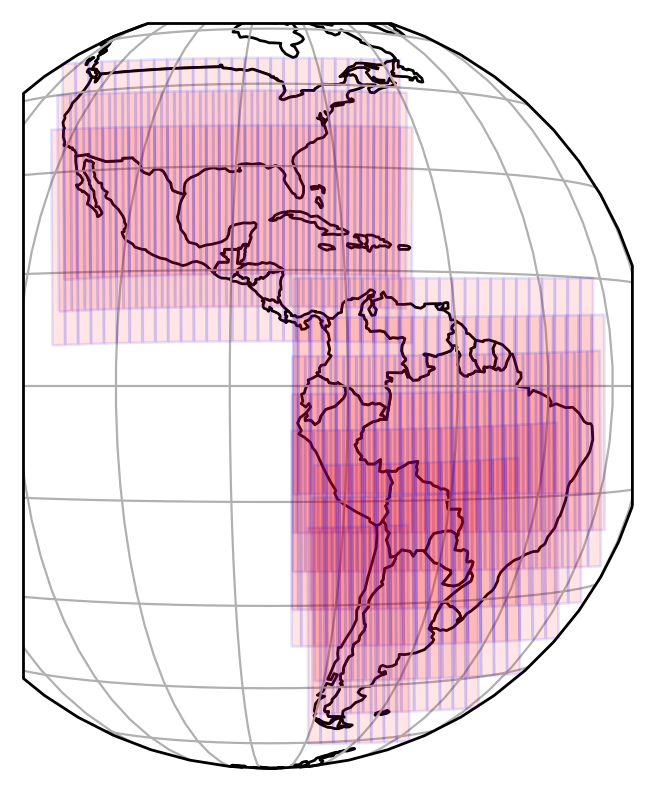

In [3]:
## We use Cartopy together with matplotlib artist objects to create layered images
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.feature as cfeat

#mpl artist object
ax1= plt.subplots(figsize=(5,5), dpi=200)
ax1 = plt.axes(projection=geo)
ax1.add_feature(cfeat.NaturalEarthFeature('cultural', 'admin_0_countries', '110m'), facecolor='white', edgecolor='black')
ax1.gridlines()

#built-in plotting function for geopandas objects
blockset.plot(ax=ax1, zorder=5, alpha=0.1, color='red', edgecolor='blue')
plt.show()

Using built-in geopandas dataset to load geospatial data and select N.am and S.am geometries. The Data is 1:110m from NaturalEarth, includes cultural and physical information (i.e. countries, pop, geometries, etc). NaturalEarth data is a free for use and supported by NACIS (North American Cartographic Information Society). http://www.naturalearthdata.com/

In [4]:
df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = df.query('continent == "North America" or continent == "South America"')[['continent', 'geometry']]
continents = world.dissolve(by='continent')

#creating a bounding envelope for Universal set
#We are generally concerned with the land masses lying between 50N and 50S
envelope = sgeom.box(-140, -50, -13, 50)
U = continents.intersection(envelope)
frguiana = df[df['name'] == 'France'].intersection(envelope) #french guiana is listed under France < Europe
U = U.union(frguiana)
U.crs = {'init' :'epsg:4326'}
U = U.to_crs(geo_proj4).buffer(0)   #.buffer(0) is a workaround commonly used in the
                                    #C GEOS package to ensure that valid geoms are labeled 'valid'

I had to buffer each scan block as a workaround to underlying floating point precision issues in the C GEOS package which
the python shapely package is wrapped around. Although, this won't be an issue with the integration into the instrument 
since each scan block will overlap the next. The ticket to fix the bug can be found here https://github.com/Toblerity/Shapely/issues/357

In [5]:
from shapely.ops import unary_union

#fixing precision issues by adding a buffer
coverage = blockset.buffer(4000).unary_union
U_set = U.unary_union.buffer(0)
print 'Containment:', coverage.contains(U_set)

#scan blocks aren't covering the Eastern portion of Nova Scotia
#so I'm subtracting the difference for the universe_set used in the algorithm
diff = U_set.difference(coverage).buffer(0)
universe_set = U_set.difference(diff).buffer(0)
print 'Difference area =', diff.area
print 'New difference area =',universe_set.difference(coverage).area 

Containment: False
Difference area = 30394715519.7
New difference area = 0.0


The plot generated below shows the new universal set in blue, which you can see excludes the eastern part of Nova Scotia.

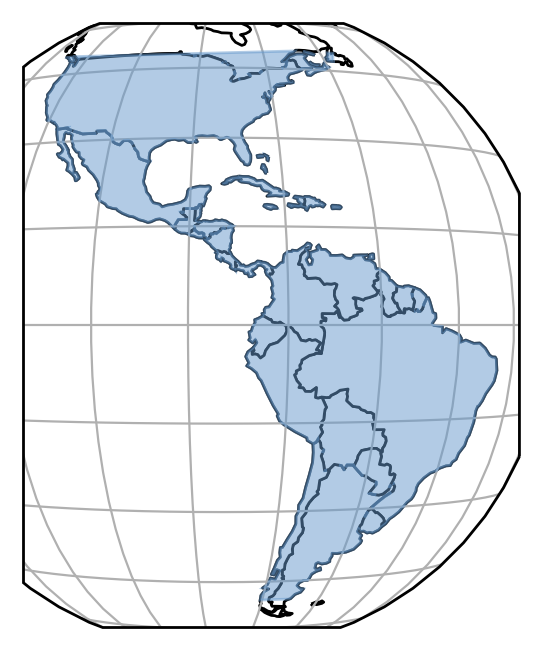

In [29]:
from descartes.patch import PolygonPatch

#plotting multipolygon geometry
BLUE = '#6699cc'
ax1 = plt.subplots(dpi=200)
ax1 = plt.axes(projection=geo)
ax1.add_feature(cfeat.NaturalEarthFeature('cultural', 'admin_0_countries', '110m'), facecolor='white', edgecolor='black')
ax1.gridlines()
ax1.add_patch(PolygonPatch(universe_set, fc=BLUE, ec=BLUE, alpha=0.5, zorder=3 ))
ax1.axis('scaled')
plt.show()

The cell below implements the Greedy Algorithm for finding a set cover. In general, the algorithm calculates the area of coverage for each subcover at each iteration and grabs the subcover with the maximum area.

In [30]:
%%time
#Greedy Algorithm for Set Cover
import numpy as np
#from shapely.validation import explain_validity

scan_blocks = blockset
scan_blocks['geometry'] = scan_blocks.buffer(4000) #buffer the scan blocks
universe = universe_set
cover_set = gpd.GeoDataFrame()
cover_set.crs = geo_proj4
covered = []
block_cost = []
ii=0 #flow control index, prevents infinite looping
max_ind = []
print('Greedy Algorithm commenced')
while( (universe.area != 0.0)  and (ii<235) ):
    block_cost = np.zeros(len(scan_blocks))
    for i in range(len(scan_blocks)):
        block_cost[i] = universe.intersection(scan_blocks.iloc[i,0]).area
    max_ind = np.argmax(block_cost)
    cover_set = cover_set.append(scan_blocks.iloc[max_ind])
    covered = cover_set.unary_union
    #print(ii,explain_validity(universe_set),explain_validity(covered)) #checks validity of geoms for debugging
    universe = universe.difference(covered).buffer(0)
    scan_blocks = scan_blocks.drop(max_ind).reset_index(drop=True)
    print ii,
    ii+=1
print('Finished.',len(cover_set),'scanning blocks chosen.')
cover_set = cover_set.reset_index(drop=True) #reset indices

Greedy Algorithm commenced
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 ('Finished.', 95, 'scanning blocks chosen.')
Wall time: 30.3 s


We can see which blocks are chosen by calling the 'lat,lon' column from our GeoDataFrame, cover_set.

In [34]:
cover_set['lat,lon']

0     -15.0,-57.8
1     -10.0,-53.3
2      -5.0,-68.2
3     -10.0,-61.3
4      -5.0,-64.6
5     -15.0,-55.8
6      -5.0,-69.9
7     -10.0,-51.1
8      -5.0,-66.4
9      -5.0,-71.6
10     30.0,-98.4
11     -5.0,-73.3
12    30.0,-100.5
13    -10.0,-48.9
14    30.0,-102.5
15     -5.0,-75.0
16    30.0,-104.6
17    -10.0,-46.5
18    30.0,-106.7
19    -10.0,-63.1
20     30.0,-88.7
21    -10.0,-44.0
22     -5.0,-76.6
23     30.0,-96.5
24     30.0,-90.6
25    -10.0,-55.4
26    -25.0,-67.5
27    30.0,-108.9
28     30.0,-92.5
29    -25.0,-65.5
         ...     
65    -20.0,-58.5
66    -30.0,-68.9
67     20.0,-66.9
68     20.0,-72.5
69     30.0,-69.2
70     20.0,-65.0
71     20.0,-83.1
72      0.0,-64.5
73      0.0,-55.0
74    -20.0,-56.4
75      0.0,-53.0
76    -15.0,-51.5
77     25.0,-87.5
78    -30.0,-76.7
79      0.0,-35.4
80     20.0,-81.3
81     20.0,-74.3
82     30.0,-67.1
83     30.0,-65.0
84     25.0,-89.3
85      0.0,-78.1
86     25.0,-91.1
87      0.0,-50.8
88    -20.0,-54.2
89      0.

The plot generated below shows us the scan blocks that the algorithm chose. We can see that it mirrors closely to what pattern a human would choose by visual analysis.

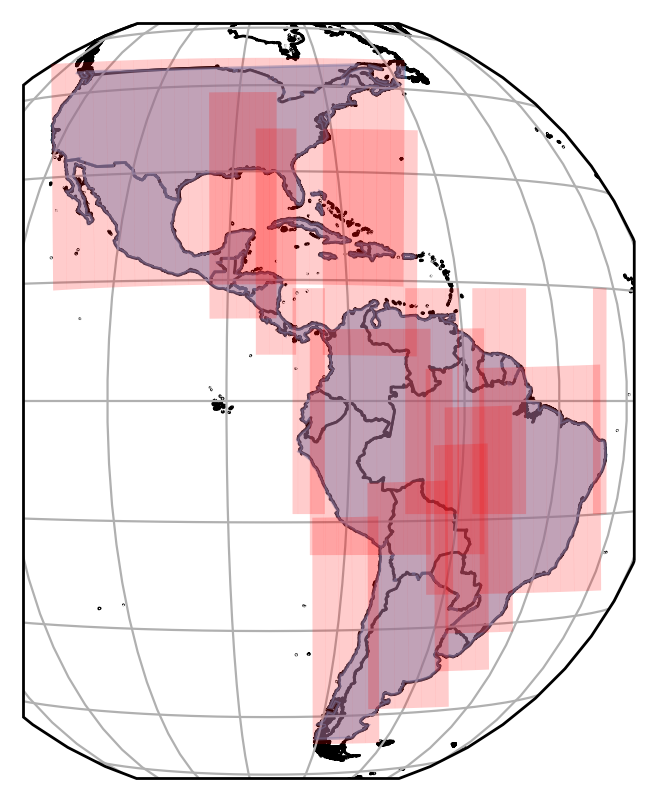

In [32]:
#mpl plot object
ax1= plt.subplots(figsize=(5,5), dpi=200)
ax1 = plt.axes(projection=geo)
ax1.add_feature(cfeat.NaturalEarthFeature('cultural', 'admin_0_countries', '10m'), facecolor='white', edgecolor='black')
ax1.gridlines()
ax1.add_patch(PolygonPatch(universe_set, fc=BLUE, ec=BLUE, alpha=0.5, zorder=4 ))
cover_set.plot(ax=ax1, zorder=5, alpha=0.2, color='red')
plt.show()